In [1]:
# Librerías
import warnings
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from datetime import datetime
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# Preparación de datos

In [2]:
disp_df = pd.read_csv('Data/full_devices.csv'
                      , encoding = 'ISO-8859-1'
                     )

In [3]:
# Modificación tipo de datos de fecha
disp_df['date'] = pd.to_datetime(disp_df['date'])
disp_df['failure'] = pd.to_numeric(disp_df['failure'])

# Quitar filas duplicadas
print(disp_df.shape)
disp_df = disp_df.drop_duplicates()
print(disp_df.shape)

# Eliminar registros después del fallo

fallos = disp_df[disp_df['failure'] == 1][['device', 'date']]

for index, row in fallos.iterrows():
    disp_df = disp_df[~((disp_df['device'] == row['device']) & (disp_df['date'] > row['date']))]

print(disp_df.shape)

(124494, 12)
(124493, 12)
(124446, 12)


## Missing Data

In [4]:
# Missing Data

unique_dates = disp_df['date'].sort_values().unique()
unique_devices = disp_df['device'].unique()
all_combinations = pd.DataFrame(list(itertools.product(unique_dates, unique_devices)), columns=['date', 'device'])

disp_df = all_combinations.merge(disp_df, on=['date', 'device'], how='left')

last_date_reported = disp_df[~disp_df['failure'].isna()].groupby('device')['date'].max().reset_index()
last_date_reported.rename(columns={'date': 'last_date_reported'}, inplace=True)

disp_df = disp_df.merge(last_date_reported, on='device')
disp_df = disp_df[disp_df['date'] <= disp_df['last_date_reported']]
disp_df = disp_df.drop(columns=['last_date_reported'])

In [5]:
disp_df.isna().mean()

date          0.000000
device        0.000000
failure       0.057656
attribute1    0.057656
attribute2    0.057656
attribute3    0.057656
attribute4    0.057656
attribute5    0.057656
attribute6    0.057656
attribute7    0.057656
attribute8    0.057656
attribute9    0.057656
dtype: float64

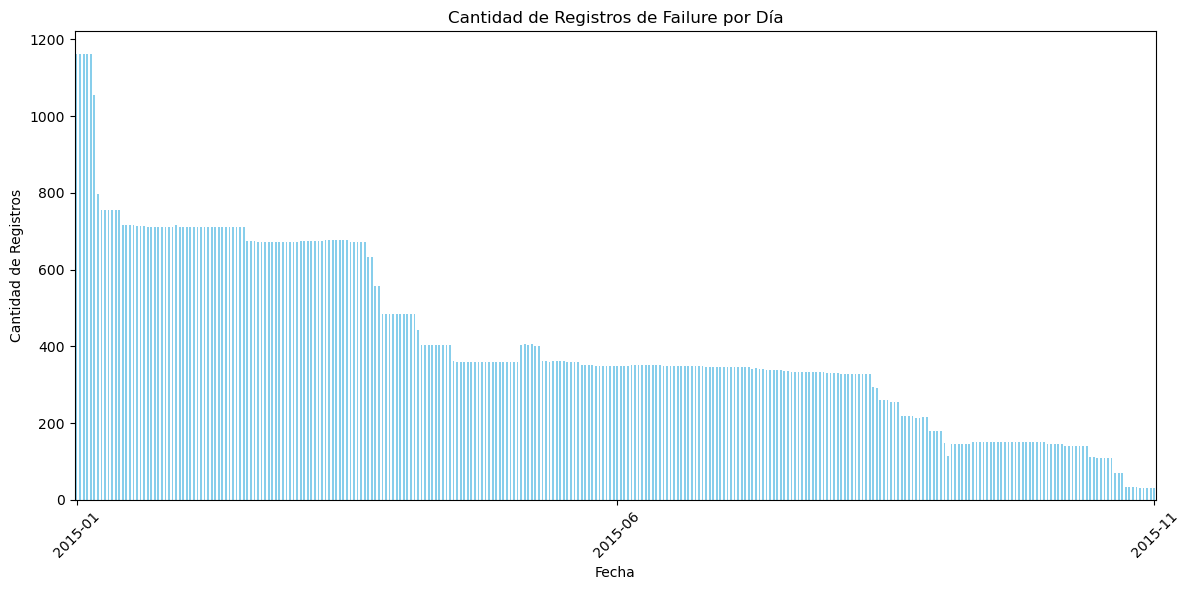

In [6]:
# Contar la cantidad de registros por día
daily_counts = disp_df.groupby('date')['failure'].agg('count').sort_index()
tick_indices = [0, len(daily_counts) // 2, len(daily_counts) - 1]
tick_labels = [daily_counts.index[i].strftime('%Y-%m') for i in tick_indices]


# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
daily_counts.plot(kind='bar', color='skyblue')
plt.title('Cantidad de Registros de Failure por Día')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Registros')
plt.xticks(tick_indices, tick_labels, rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [7]:
# Para valores na de fallo imputar 0

disp_df['failure'] = disp_df['failure'].fillna(0)

# Para los demás utilizar una interpolación cuadrática

disp_df.iloc[:, 3:] = disp_df.iloc[:, 3:].interpolate(method='quadratic')

In [8]:
disp_df.isna().mean()

date          0.0
device        0.0
failure       0.0
attribute1    0.0
attribute2    0.0
attribute3    0.0
attribute4    0.0
attribute5    0.0
attribute6    0.0
attribute7    0.0
attribute8    0.0
attribute9    0.0
dtype: float64

<Axes: ylabel='device'>

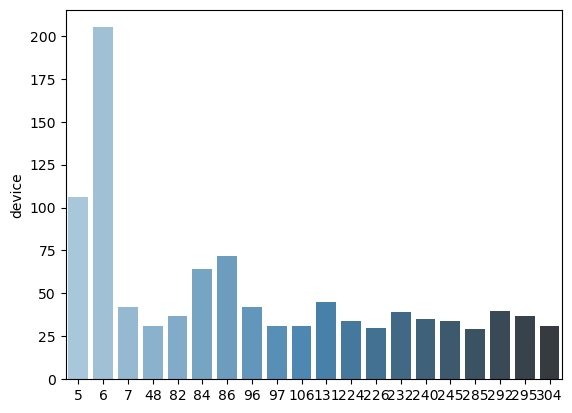

In [9]:
sns.barplot(x=disp_df['device'].value_counts().value_counts().index[0:20]
                , y=disp_df['device'].value_counts().value_counts()[0:20]
                ,palette='Blues_d'
               )

In [10]:
# Generar dataset para dispositivos nuevos y otro para con historial 

dispositivos_suficientes_datos = disp_df['device'].value_counts()
dispositivos_suficientes_datos = dispositivos_suficientes_datos[dispositivos_suficientes_datos >= 8].index
disp_nuevos_df = disp_df[~disp_df['device'].isin(dispositivos_suficientes_datos)].reset_index(drop = True)
disp_hist_df = disp_df[disp_df['device'].isin(dispositivos_suficientes_datos)].reset_index(drop = True)

print(disp_nuevos_df.shape[0], disp_hist_df.shape[0])

2061 129999


In [11]:
# Estandarizacion
columnas_para_escalar = disp_df.select_dtypes(include=['int64', 'float64']).columns[1:]

scaler = StandardScaler()
disp_hist_df[columnas_para_escalar] = scaler.fit_transform(disp_hist_df[columnas_para_escalar])

In [12]:
# Generacion de variable objetivo
disp_hist_df['next_day_failure'] = pd.to_numeric(disp_hist_df.groupby('device')['failure'].shift(-1).fillna(0))

# EDA

Primero hacemos un eda general para revisar si hay relaciones entre los atributos

In [13]:
# Seleccionar solo las columnas numéricas para el análisis
columnas_numericas = disp_hist_df.select_dtypes(include=['int64', 'float64']).columns

# Calcular estadísticas descriptivas, incluyendo simetría (skewness) y curtosis
numerical_summary = disp_hist_df[columnas_numericas].describe()
skewness = disp_hist_df[columnas_numericas].skew()
kurtosis = disp_hist_df[columnas_numericas].kurtosis()
combined_stats = pd.concat([numerical_summary, pd.DataFrame(skewness, columns=['skewness']).T, pd.DataFrame(kurtosis, columns=['kurtosis']).T], axis=0)

combined_stats

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,next_day_failure
count,129999.000000,1.299990e+05,1.299990e+05,1.299990e+05,1.299990e+05,1.299990e+05,1.299990e+05,1.299990e+05,1.299990e+05,1.299990e+05,129999.000000
mean,0.000800,-3.498083e-18,2.186302e-17,-1.836494e-17,-1.093151e-17,1.749042e-16,-5.946742e-16,-8.745209e-18,-8.745209e-18,3.498083e-18,0.000800
std,0.028273,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,0.028273
min,0.000000,-2.729814e+01,-5.634612e-01,-7.511735e-02,-5.985084e-02,-8.378231e-01,-2.562541e+00,-1.722821e-01,-1.722821e-01,-8.600890e-02,0.000000
25%,0.000000,-1.713291e-01,-7.248255e-02,-7.511735e-02,-5.984782e-02,-3.907425e-01,-3.894065e-01,-3.618743e-02,-3.618743e-02,-8.600890e-02,0.000000
50%,0.000000,-3.386893e-02,-7.248255e-02,-7.511735e-02,-5.984782e-02,-2.630051e-01,-1.055399e-01,-3.618743e-02,-3.618743e-02,-8.600890e-02,0.000000
75%,0.000000,1.015093e-01,-7.248255e-02,-7.511735e-02,-5.984782e-02,-1.352678e-01,4.809041e-01,-3.618743e-02,-3.618743e-02,-8.600890e-02,0.000000
max,1.000000,1.545489e+01,3.180796e+01,2.091863e+01,4.631467e+01,5.357437e+00,4.206342e+00,1.194077e+02,1.194077e+02,1.924120e+01,1.000000
skewness,35.313170,-2.256389e+00,2.524317e+01,1.819346e+01,3.655815e+01,3.546445e+00,-1.288027e-01,8.206842e+01,8.206842e+01,1.669462e+01,35.313170
kurtosis,1245.039117,1.909961e+02,7.085866e+02,3.542000e+02,1.509106e+03,1.270259e+01,2.380765e+00,8.403124e+03,8.403124e+03,2.951991e+02,1245.039117


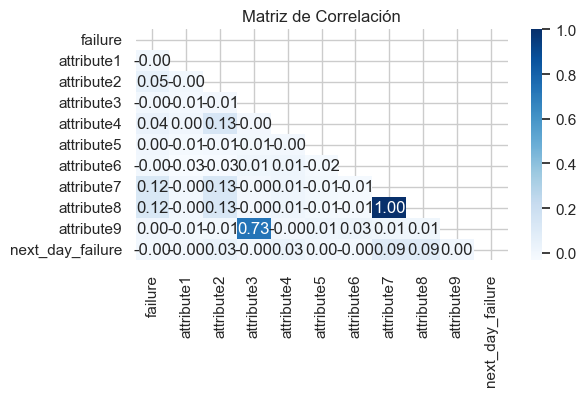

In [14]:
# Correlación
corr = disp_hist_df[columnas_numericas].corr()
matrix = np.triu(corr)

sns.set(style='whitegrid')

plt.figure(figsize=(6, 3))
sns.heatmap(corr
            , annot=True
            , mask=matrix
            , fmt='.2f'
            , cmap='Blues'
           )
plt.title('Matriz de Correlación', fontsize=12)
plt.show()

Se elimina el atributo 8 debido a su correlacion perfecta con el atributo 7.

In [15]:
disp_hist_df.drop('attribute8', axis=1, inplace=True)

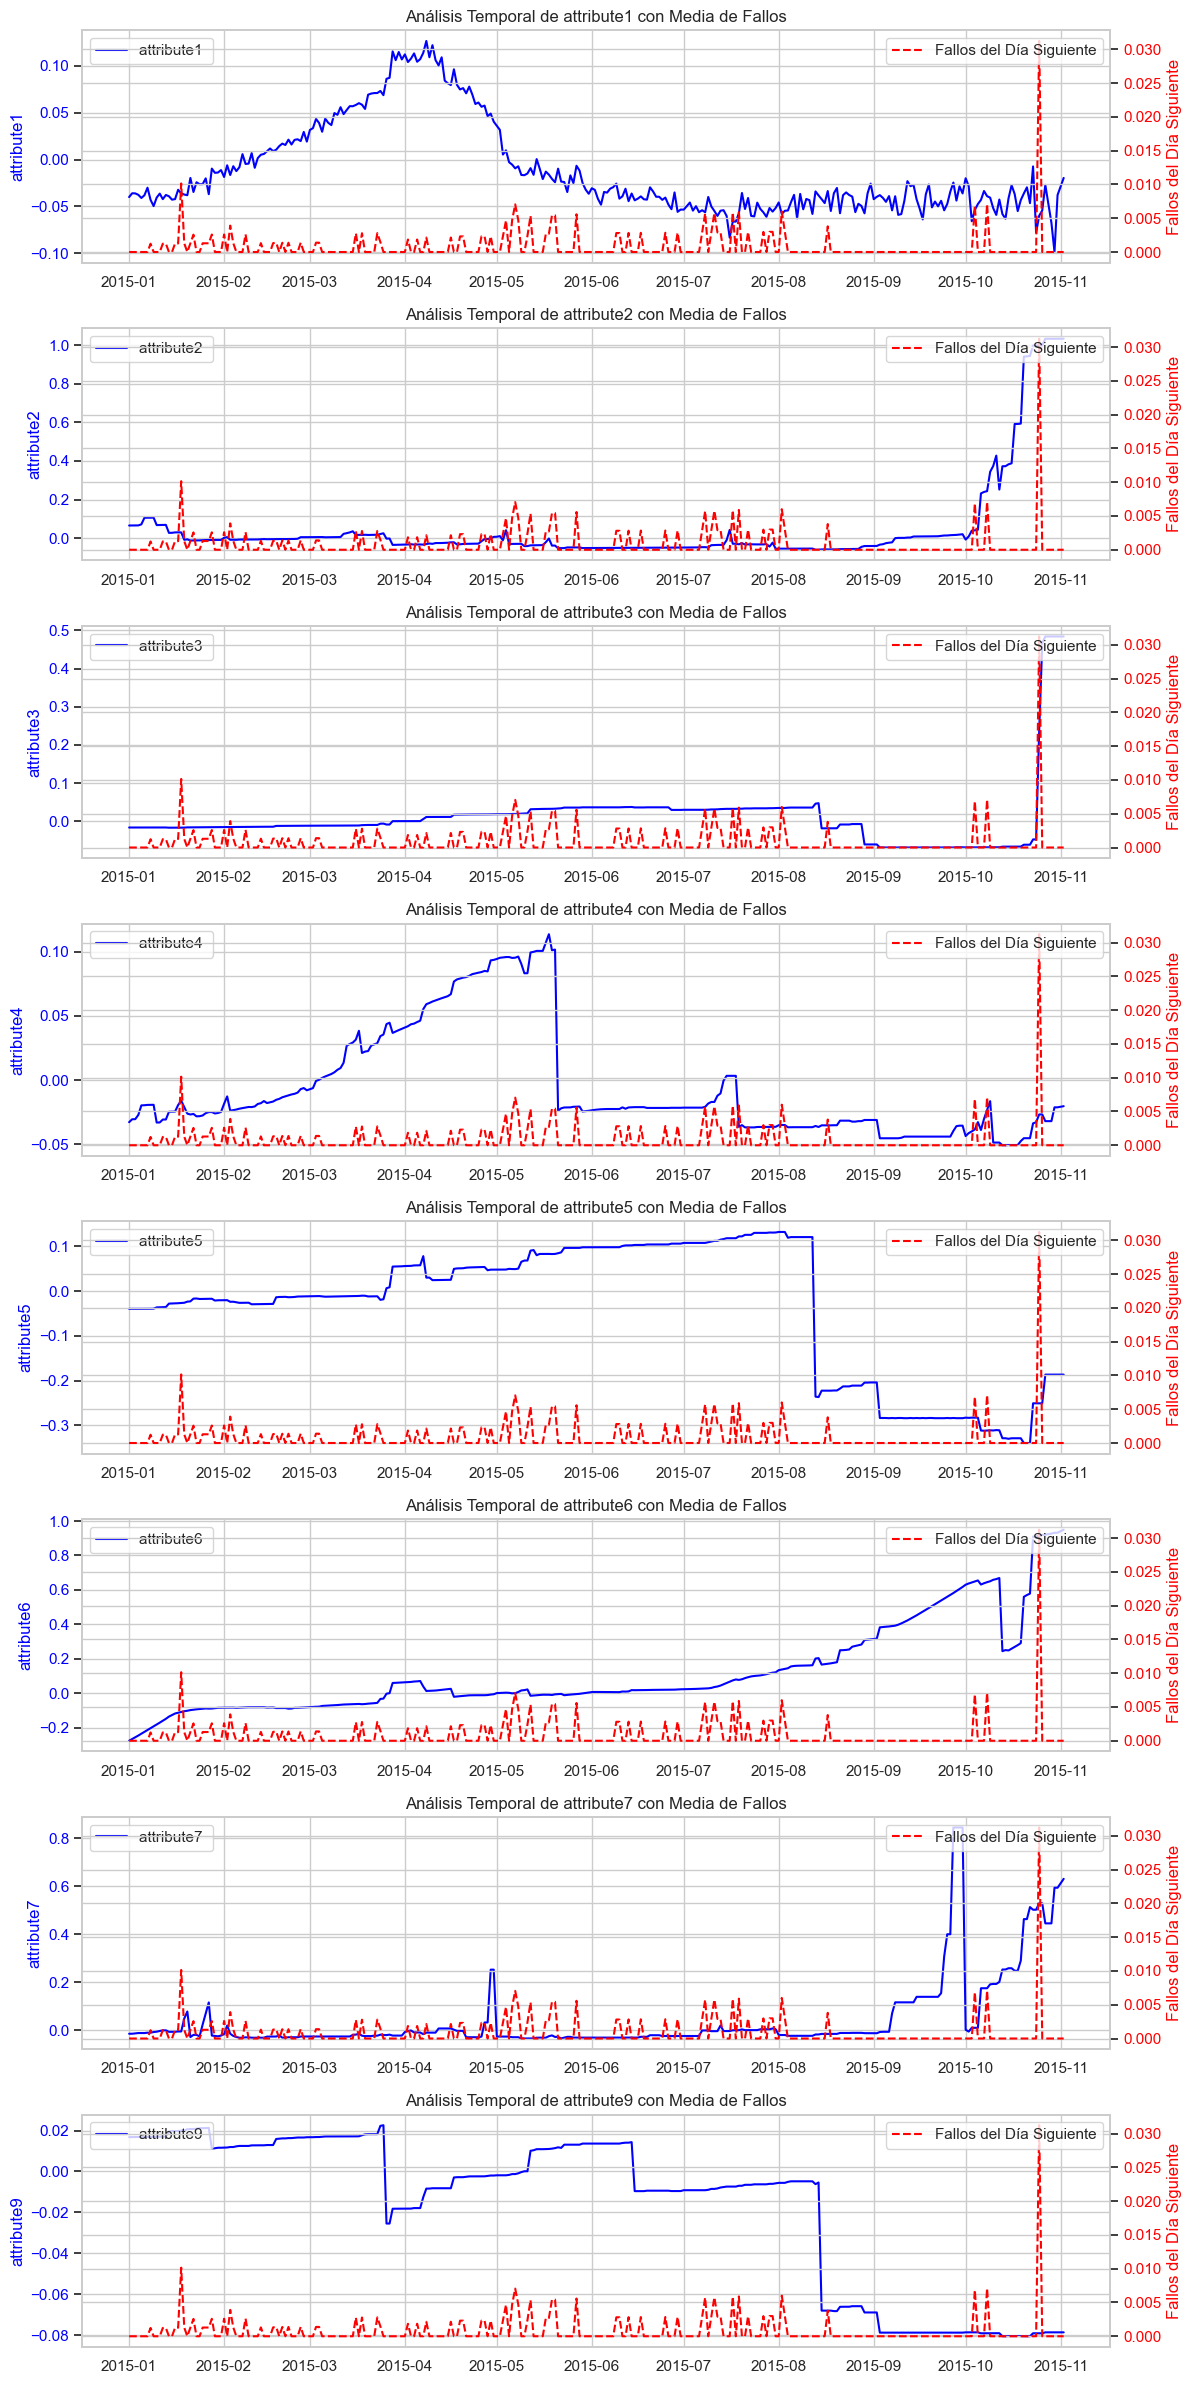

In [16]:
columnas_numericas = disp_hist_df.select_dtypes(include=['int64', 'float64']).columns[1:9]


media_diaria_atributos_y_fallo = disp_hist_df.groupby('date')[list(columnas_numericas) + ['next_day_failure']].mean()
fig, axes = plt.subplots(len(columnas_numericas), 1, figsize=(12, 3 * len(columnas_numericas)))

for i, atributo in enumerate(columnas_numericas):
    
    ax = axes[i]
    ax2 = ax.twinx()
    
    # Gráfico de la serie temporal del atributo
    ax.plot(media_diaria_atributos_y_fallo.index, media_diaria_atributos_y_fallo[atributo], label=f'{atributo} ', color='blue')
    ax.set_ylabel(f'{atributo}', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    
    # Gráfico de la media de fallos del dia siguiente
    ax2.plot(media_diaria_atributos_y_fallo.index, media_diaria_atributos_y_fallo['next_day_failure'], label='Fallos del Día Siguiente', color='red', linestyle='--')
    ax2.set_ylabel('Fallos del Día Siguiente', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    ax.set_title(f'Análisis Temporal de {atributo} con Media de Fallos')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


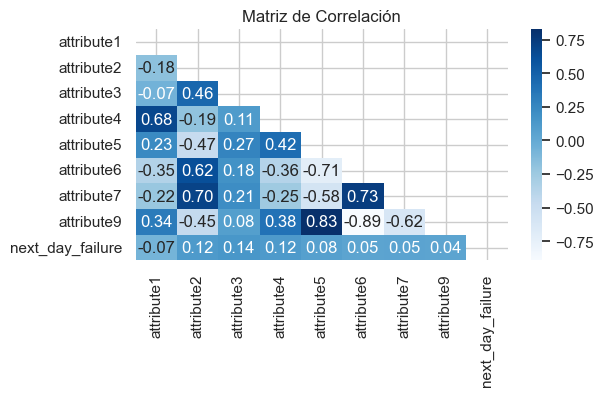

In [17]:
# Correlación
corr = media_diaria_atributos_y_fallo.corr()
matrix = np.triu(corr)

sns.set(style='whitegrid')

plt.figure(figsize=(6, 3))
sns.heatmap(corr
            , annot=True
            , mask=matrix
            , fmt='.2f'
            , cmap='Blues'
           )
plt.title('Matriz de Correlación', fontsize=12)
plt.show()

# Análisis por dispositivo

In [18]:
# Generar dataset por días de fallo

#Dataset con fallo

dias_de_fallo = disp_hist_df[disp_hist_df['failure'] == 1][['device', 'date']]

dataset_fallo_60_dias = pd.DataFrame()

for _, row in dias_de_fallo.iterrows():
    device = row['device']
    fallo_date = row['date']
    start_date = fallo_date - pd.Timedelta(days=60)

    registros = disp_hist_df[(disp_hist_df['device'] == device)
                            & (disp_hist_df['date'] >= start_date)
                            & (disp_hist_df['date'] <= fallo_date)
                           ]
    
    dataset_fallo_60_dias = pd.concat([dataset_fallo_60_dias, registros], axis=0)

dataset_fallo_60_dias.reset_index(drop=True, inplace=True)

# Dataset sin fallo

dispositivos_sin_fallo = disp_hist_df[~disp_hist_df['device'].isin(dias_de_fallo['device'])]['device'].unique()

dataset_sin_fallo_60_dias = pd.DataFrame()

for device in dispositivos_sin_fallo:
    registros_device = disp_hist_df[disp_hist_df['device'] == device]

    ultima_fecha = registros_device['date'].max()
    fecha_inicio = ultima_fecha - pd.Timedelta(days=60)

    registros = registros_device[(registros_device['date'] >= fecha_inicio) & 
                                 (registros_device['date'] <= ultima_fecha)]
    
    dataset_sin_fallo_60_dias = pd.concat([dataset_sin_fallo_60_dias, registros], axis=0)

dataset_sin_fallo_60_dias.reset_index(drop=True, inplace=True)

# Dataset final

dataset_fallo_60_dias['tipo'] = 'Con Fallo'
dataset_sin_fallo_60_dias['tipo'] = 'Sin Fallo'

disp_esc_60_dias_df = pd.concat([dataset_fallo_60_dias, dataset_sin_fallo_60_dias], axis=0)

disp_esc_60_dias_df = disp_esc_60_dias_df.sort_values(by='date').reset_index(drop=True)

ultima_fecha_por_dispositivo = disp_esc_60_dias_df.groupby('device')['date'].max().reset_index()
ultima_fecha_por_dispositivo.columns = ['device', 'last_day_reported']

disp_esc_60_dias_df = disp_esc_60_dias_df.merge(ultima_fecha_por_dispositivo, on='device', how='left')

disp_esc_60_dias_df['days_till_failure_or_last_report'] = pd.to_numeric((disp_esc_60_dias_df['last_day_reported'] - disp_esc_60_dias_df['date']).dt.days)

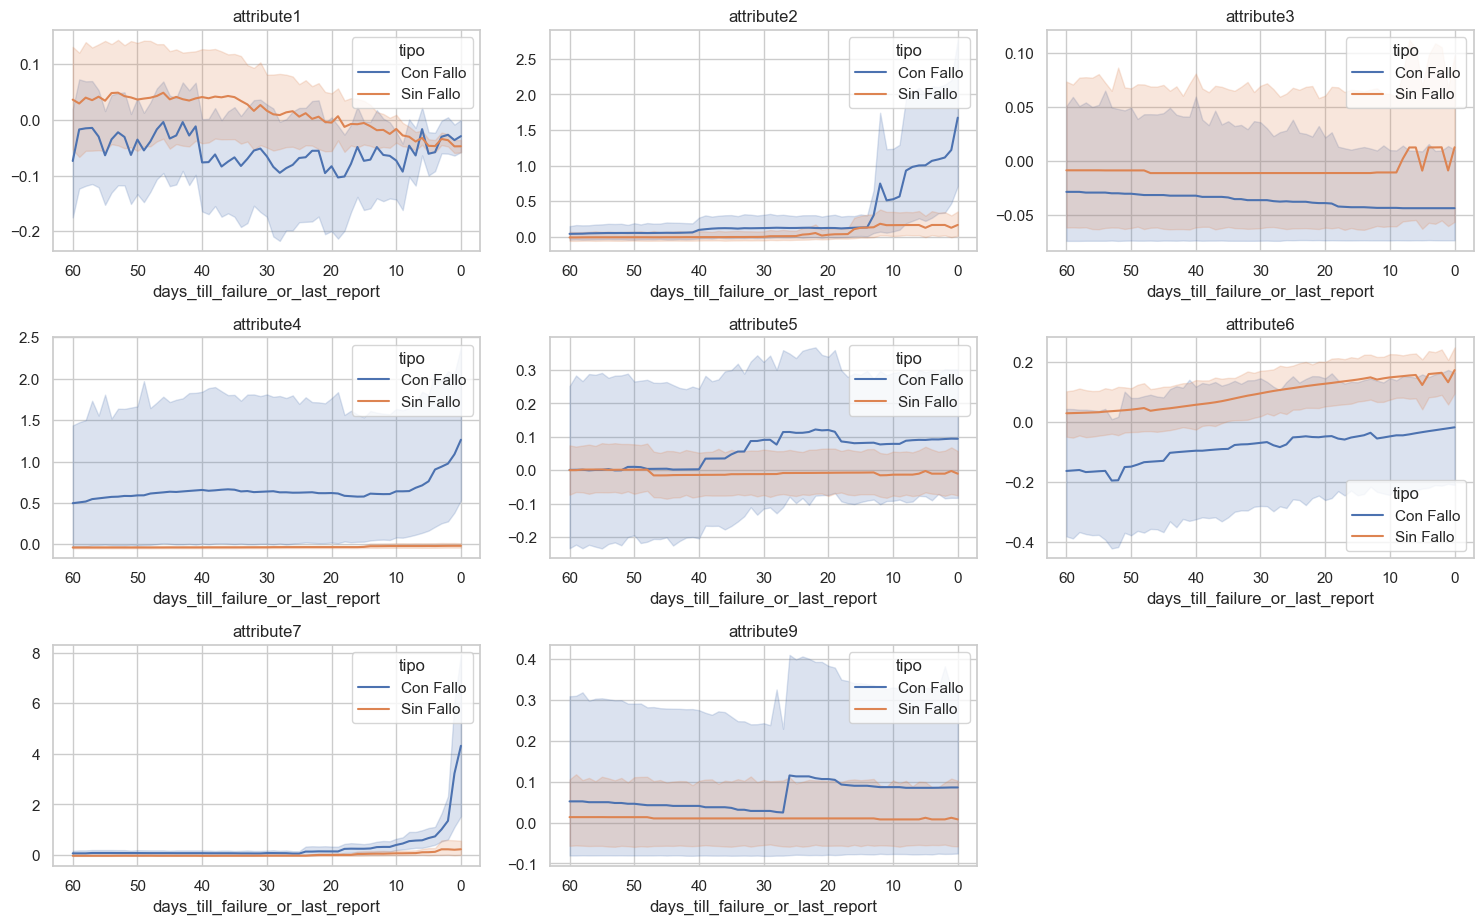

In [19]:
plt.figure(figsize=(15, 12))

for i, var in enumerate(disp_esc_60_dias_df.columns[3:11]):
    plt.subplot(4, 3, i + 1)
    ax =sns.lineplot(data=disp_esc_60_dias_df
                     ,x='days_till_failure_or_last_report'
                     ,y=var
                     ,hue='tipo'
                    )
    ax.invert_xaxis()
    plt.title(var)
    plt.ylabel('')

plt.tight_layout()
plt.show()

Debido al comportamiento observado se modifican los atributos segun tres grupos identificados:
 - **Variables Constantes:** Los atributos 1 y 3 parecen tener una media constante inferior cuando van a fallar. (Estacionaria)
 - **Variables Crecimiento Constante:** El atributo 6 parece crecer de forma constante hasta la falla (pero a una escala inferior si no falla). (Estacionaria)
 - **Variables con Salto Constantes:** Los atributos 5 y 9 parecen tener un saldo entre los 30 y 40 días. Para estas se revisara la diferencia 40 dias antes. (No Estacionaria)
 - **Variables con Exponencial:** Los atributos 2, 4 y 7 parecen un aumento en los utlimos días que cada vez se acelera mas. (No Estacionaria)

# Modelado

## Generación de Input Serie de Tiempo

In [ ]:
metricas_rendimiento = pd.DataFrame(columns=['device', 'attribute', 'mse'])

# ARIMA Atributos

for atributo in [x for x in list(disp_esc_df.columns) if ('attr' in x) & ('2'  in x)]:
    print('empieza atributo', str(atributo))
    disp_esc_df[atributo + '_lead'] = np.nan
    disp_esc_df[atributo + '_lead2'] = np.nan
    disp_esc_df[atributo + '_lead3'] = np.nan
    for device in ['W1F1DA5ÿ']:#disp_esc_df['device'].unique():
        data_device = disp_esc_df[disp_esc_df['device'] == device][['date', atributo]].set_index('date')
        print('empieza device', str(device))
        for date in data_device.index:
            train_data = data_device.loc[(date - pd.Timedelta(days=(20 if atributo in ['attribute2'
                                                                                       ,'attribute4'
                                                                                       ,'attribute7'
                                                                                      ] else
                                                                    40 if atributo in ['attribute5'
                                                                                       ,'attribute9'
                                                                                      ] else 60 
                                                                   )
                                                             )
                                         ):date
                                        ]
            
            model = pm.auto_arima(train_data,
                                  start_p=1,
                                    start_q=1,
                                    test="adf",
                                    #max_p=3,
                                    #max_q=3,
                                    m=1,
                                    d=None,
                                    seasonal=False,
                                    start_P=0,
                                    D=0,
                                    trace=True,
                                    error_action="ignore",
                                    suppress_warnings=True,
                                    stepwise=True
                                 )
            #print(model.predict(n_periods=1))
            disp_esc_df.loc[(disp_esc_df['device'] == device) & (disp_esc_df['date'] == date), atributo + '_lead'] = model.predict(n_periods=1)
            try:
                disp_esc_df.loc[(disp_esc_df['device'] == device) & (disp_esc_df['date'] == date), atributo + '_lead2'] = model.predict(n_periods=2)
            except:
                disp_esc_df.loc[(disp_esc_df['device'] == device) & (disp_esc_df['date'] == date), atributo + '_lead2'] = np.nan
            
            try:
                disp_esc_df.loc[(disp_esc_df['device'] == device) & (disp_esc_df['date'] == date), atributo + '_lead3'] = model.predict(n_periods=3)
            except:
                disp_esc_df.loc[(disp_esc_df['device'] == device) & (disp_esc_df['date'] == date), atributo + '_lead3'] = np.nan